In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
%matplotlib inline

import os, math
import keras.backend as K
from numpy import random
from __future__ import division
from sklearn import dummy, metrics, cross_validation, ensemble
from keras.layers import Input, Embedding, Flatten, Dropout, Conv2D, merge, normalization, MaxPooling1D,Dense, Dot, Concatenate, Merge, Conv1D, Add,add
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.models import Model
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

import keras
import deepdish as dd
from read_activations import *

In [2]:
dataset = pd.read_csv("/home/jvidyala/data/train_triplets.txt",sep="\t",skiprows=1,names="user_id,song_id,play_count".split(","))


In [3]:
n_users = len(dataset.user_id.unique())
n_songs = len(dataset.song_id.unique())

dataset.user_id = dataset.user_id.astype('category')
dataset.song_id = dataset.song_id.astype('category')

dataset.user_id = dataset.user_id.cat.codes.values
dataset.song_id = dataset.song_id.cat.codes.values

In [8]:
dummy_classifier = dummy.DummyClassifier(strategy='prior')
dummy_classifier.fit(dataset[['user_id','song_id']],dataset.play_count)
metrics.mean_absolute_error(dummy_classifier.predict(dataset[['user_id','song_id']]),dataset.play_count)

1.8668588858981612

In [12]:
dataset.head(5)

,user_id,song_id,play_count
0,732659,9365,1
1,732659,16962,2
2,732659,19513,1
3,732659,19536,1
4,732659,24689,1


Initial test for memory issues on target categorical for 100,000 rows

UPDATE: 100,000 throw mem error during training. Trying 10,000



In [6]:
k = 10000

size = max(dataset.play_count)
y = np.zeros((k,size-1))
y[np.arange(k),dataset.play_count.head(k)-1] = 1

a_songid, b_songid, a_userid, b_userid, a_y, b_y = cross_validation.train_test_split(songids,userids,y,test_size=0.2)

NameError: name 'y' is not defined

Testing with integer targets instead of categorical one-hot encoded vector


In [4]:
k=100000
y = dataset.play_count.head(k)
songids = dataset.song_id.head(k).values
userids = dataset.user_id.head(k).values

a_songid, b_songid, a_userid, b_userid, a_y, b_y = cross_validation.train_test_split(songids,userids,y,test_size=0.1)

Hold two out validation testing

In [4]:
k = 50000
a_songid, b_songid, a_userid, b_userid, a_y, b_y = [np.zeros(1) for i in range(6)]


for user in dataset.user_id.head(k).unique():
    a_songid = np.append(a_songid,dataset.loc[dataset['user_id'] == user].iloc[:-2].song_id)
    a_userid = np.append(a_userid,dataset.loc[dataset['user_id'] == user].iloc[:-2].user_id)
    a_y = np.append(a_y,dataset.loc[dataset['user_id'] == user].iloc[:-2].play_count)

    b_songid = np.append(b_songid,dataset.loc[dataset['user_id'] == user].tail(2).song_id)
    b_userid = np.append(b_userid,dataset.loc[dataset['user_id'] == user].tail(2).user_id)
    b_y = np.append(b_y,dataset.loc[dataset['user_id'] == user].tail(2).play_count)
    

a_songid = a_songid[1:]
b_songid = b_songid[1:]
a_userid = a_userid[1:]
b_userid = b_userid[1:]
a_y = a_y[1:]
b_y = b_y[1:]

In [16]:
dd.io.save('/home/jvidyala/model_sample_data/a_songid.h5',a_songid)
dd.io.save('/home/jvidyala/model_sample_data/b_songid.h5',b_songid)
dd.io.save('/home/jvidyala/model_sample_data/a_userid.h5',a_userid)
dd.io.save('/home/jvidyala/model_sample_data/b_userid.h5',b_userid)
dd.io.save('/home/jvidyala/model_sample_data/a_y.h5',a_y)
dd.io.save('/home/jvidyala/model_sample_data/b_y.h5',b_y)

In [17]:
a_songid = dd.io.load('/home/jvidyala/model_sample_data/a_songid.h5')
b_songid = dd.io.load('/home/jvidyala/model_sample_data/b_songid.h5')
a_userid = dd.io.load('/home/jvidyala/model_sample_data/a_userid.h5')
b_userid = dd.io.load('/home/jvidyala/model_sample_data/b_userid.h5')
a_y = dd.io.load('/home/jvidyala/model_sample_data/a_y.h5')
b_y = dd.io.load('/home/jvidyala/model_sample_data/b_y.h5')


MODEL 1

In [57]:
song_input = Input(shape=[1])
song_embedding = Flatten()(Embedding(n_songs+1, 16)(song_input))
song_vec = Dropout(0.5)(song_embedding)

user_input = Input(shape=[1])
user_embedding = Flatten()(Embedding(n_users+1, 16)(user_input))
user_vec = Dropout(0.5)(user_embedding)
    
input_vecs = Concatenate()([song_vec,user_vec])    
x = Dense(128, activation='relu')(input_vecs)

y = Dense(1)(x)
model = Model(inputs=[song_input,user_input],outputs=y)
model.compile(loss='mse',optimizer='adam')

Testing model with no regularization, single Dense layer

In [58]:
history = model.fit([a_songid,a_userid], a_y,
                   epochs = 20,
                   validation_data=([b_songid, b_userid], b_y),
                   batch_size=64, shuffle=True)

Train on 47992 samples, validate on 2020 samples
Epoch 1/20
47992/47992 [==============================] - 21s 445us/step - loss: 103.8698 - val_loss: 41.8556
Epoch 2/20
47992/47992 [==============================] - 21s 439us/step - loss: 99.7874 - val_loss: 39.0839
Epoch 3/20
47992/47992 [==============================] - 21s 440us/step - loss: 96.9017 - val_loss: 38.8584
Epoch 4/20
47992/47992 [==============================] - 21s 440us/step - loss: 93.3913 - val_loss: 39.3966
Epoch 5/20
47992/47992 [==============================] - 21s 440us/step - loss: 90.4468 - val_loss: 40.1802
Epoch 6/20
47992/47992 [==============================] - 21s 439us/step - loss: 86.9144 - val_loss: 41.0237
Epoch 7/20
47992/47992 [==============================] - 21s 439us/step - loss: 86.7856 - val_loss: 40.7780
Epoch 8/20
47992/47992 [==============================] - 21s 439us/step - loss: 84.3390 - val_loss: 42.8583
Epoch 9/20
47992/47992 [==============================] - 21s 439us/step - los

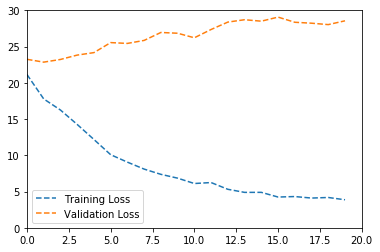

In [98]:
plt.plot(history.history['loss'],'--', label='Training Loss')
plt.plot(history.history['val_loss'],'--',label='Validation Loss')
plt.axis([0,20,0,30])
plt.legend()

MODEL 2

In [10]:
song_input = Input(shape=[1])
song_embedding = Flatten()(Embedding(n_songs+1, 32)(song_input))
song_vec = (song_embedding)

user_input = Input(shape=[1])
user_embedding = Flatten()(Embedding(n_users+1, 32)(user_input))
user_vec = (user_embedding)
    
input_vecs = Concatenate()([song_vec,user_vec])    
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.7)(x)
x = Dense(128, activation='relu')(input_vecs)


y = Dense(1)(x)
model = Model(inputs=[song_input,user_input],outputs=y)
model.compile(loss='mse',optimizer='adam')

In [11]:
history = model.fit([a_songid,a_userid], a_y,
                   epochs = 20,
                   validation_data=([b_songid, b_userid], b_y),
                   batch_size=64, shuffle=True)

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 26s 3ms/step - loss: 21.7074 - val_loss: 14.8529
Epoch 2/20
9000/9000 [==============================] - 7s 818us/step - loss: 17.9552 - val_loss: 14.4946
Epoch 3/20
9000/9000 [==============================] - 7s 819us/step - loss: 15.2416 - val_loss: 15.5579
Epoch 4/20
9000/9000 [==============================] - 7s 819us/step - loss: 12.2822 - val_loss: 15.9452
Epoch 5/20
9000/9000 [==============================] - 7s 818us/step - loss: 9.8823 - val_loss: 17.0222
Epoch 6/20
9000/9000 [==============================] - 7s 818us/step - loss: 8.1399 - val_loss: 18.5339
Epoch 7/20
9000/9000 [==============================] - 7s 819us/step - loss: 6.9403 - val_loss: 20.4302
Epoch 8/20
9000/9000 [==============================] - 7s 821us/step - loss: 6.1452 - val_loss: 22.2555
Epoch 9/20
9000/9000 [==============================] - 7s 828us/step - loss: 5.3489 - val_loss: 24.0473
Epoc

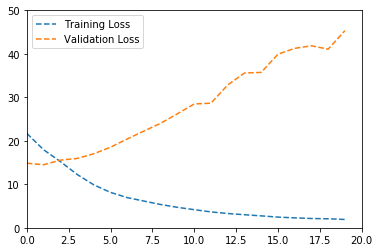

In [12]:
plt.plot(history.history['loss'],'--', label='Training Loss')
plt.plot(history.history['val_loss'],'--',label='Validation Loss')
plt.axis([0,20,0,50])a
plt.legend()

MODEL 3

Introduced dropout to embedding layers. Introduced learning rate scheduler

In [59]:
song_input = Input(shape=[1])
song_embedding = Flatten()(Embedding(n_songs+1, 16)(song_input))
song_vec = Dropout(0.4)(song_embedding)

user_input = Input(shape=[1])
user_embedding = Flatten()(Embedding(n_users+1, 16)(user_input))
user_vec = Dropout(0.4)(user_embedding)
    
input_vecs = Concatenate()([song_vec,user_vec])    
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.7)(x)
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.7)(x)
x = Dense(128, activation='relu')(input_vecs)

epochs = 20
learning_rate = 0.001
decay_rate = learning_rate * math.pow(0.5, math.floor(epochs/5))

y = Dense(1)(x)
model = Model(inputs=[song_input,user_input],outputs=y)
adam = Adam(decay=decay_rate,)
model.compile(loss='mse',optimizer='adam')

In [ ]:
history = model.fit([a_songid,a_userid], a_y,
                   epochs = 20,
                   validation_data=([b_songid, b_userid], b_y),
                   batch_size=64, shuffle=True)

Train on 47992 samples, validate on 2020 samples
Epoch 1/20
47992/47992 [==============================] - 21s 443us/step - loss: 103.4919 - val_loss: 41.2713
Epoch 2/20
47992/47992 [==============================] - 21s 437us/step - loss: 99.4211 - val_loss: 39.0050
Epoch 3/20
47992/47992 [==============================] - 21s 438us/step - loss: 95.5152 - val_loss: 38.4113
Epoch 4/20
47992/47992 [==============================] - 21s 436us/step - loss: 91.4723 - val_loss: 39.5683
Epoch 5/20
47992/47992 [==============================] - 21s 434us/step - loss: 88.7254 - val_loss: 40.8483
Epoch 6/20
47992/47992 [==============================] - 21s 437us/step - loss: 85.6078 - val_loss: 44.3696
Epoch 7/20
47992/47992 [==============================] - 21s 435us/step - loss: 83.2688 - val_loss: 43.0007
Epoch 8/20
47992/47992 [==============================] - 21s 435us/step - loss: 80.9161 - val_loss: 44.7246
Epoch 9/20
47992/47992 [==============================] - 21s 436us/step - los

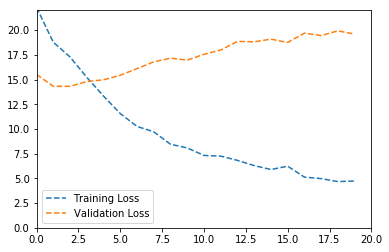

In [28]:
plt.plot(history.history['loss'],'--', label='Training Loss')
plt.plot(history.history['val_loss'],'--',label='Validation Loss')
plt.axis([0,20,0,22])
plt.legend()

MODEL 4

Tried higher initial learning rate, exponential decay rate=0.5

Higher dropout for embeddings (0.6), decay_rate = 0.7
Lower latent factors per embedding
Added biases



In [49]:
epochs = 20
learning_rate = 0.05
decay_rate = learning_rate * math.pow(0.7, math.floor(epochs/5))

song_input = Input(shape=[1])
song_embedding = Flatten()(Embedding(n_songs+1, 10)(song_input))
song_vec = Dropout(0.2)(song_embedding)


user_input = Input(shape=[1])
user_embedding = Flatten()(Embedding(n_users+1, 10)(user_input))
user_vec = Dropout(0.2)(user_embedding)

song_bias = Embedding(input_dim=n_songs,output_dim=1,input_length=1)(song_input)
user_bias = Embedding(input_dim=n_users,output_dim=1,input_length=1)(user_input)

input_vecs = Concatenate()([song_vec,user_vec]) 
x = add([input_vecs,song_bias,user_bias])
x = Dense(128, activation='relu')(x)
x = Dropout(0.6)(x)
x = normalization.BatchNormalization()(x)
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.6)(x)
x = normalization.BatchNormalization()(x)
x = Dense(128, activation='relu')(input_vecs)

y = Dense(1)(x)
model = Model(inputs=[song_input,user_input],outputs=y)
adam = Adam(decay=decay_rate,)
model.compile(loss='mse',optimizer='adam')

In [45]:
history = model.fit([a_songid,a_userid], a_y,
                   epochs = 20,
                   validation_data=([b_songid, b_userid], b_y),
                   batch_size=64, shuffle=True)

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 4s 423us/step - loss: 22.3353 - val_loss: 15.0742
Epoch 2/20
9000/9000 [==============================] - 3s 305us/step - loss: 18.9231 - val_loss: 14.3062
Epoch 3/20
9000/9000 [==============================] - 3s 299us/step - loss: 17.2396 - val_loss: 14.3708
Epoch 4/20
9000/9000 [==============================] - 3s 305us/step - loss: 14.9546 - val_loss: 14.8930
Epoch 5/20
9000/9000 [==============================] - 3s 302us/step - loss: 12.6607 - val_loss: 15.6758
Epoch 6/20
9000/9000 [==============================] - 3s 303us/step - loss: 10.9195 - val_loss: 16.9945
Epoch 7/20
9000/9000 [==============================] - 3s 302us/step - loss: 9.4412 - val_loss: 17.0216
Epoch 8/20
9000/9000 [==============================] - 3s 301us/step - loss: 8.3305 - val_loss: 18.0874
Epoch 9/20
9000/9000 [==============================] - 3s 302us/step - loss: 7.6689 - val_loss: 18.1125
E

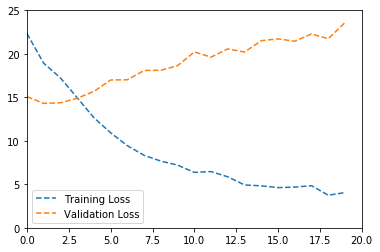

In [46]:
plt.plot(history.history['loss'],'--', label='Training Loss')
plt.plot(history.history['val_loss'],'--',label='Validation Loss')
plt.axis([0,20,0,25])
plt.legend()

Added regularization
**Implement grid search for hyperparameter optimization

In [73]:
epochs = 20
learning_rate = 0.05
decay_rate = learning_rate * math.pow(0.7, math.floor(epochs/5))

song_input = Input(shape=[1])
song_embedding = Flatten()(Embedding(input_dim=n_songs+1, output_dim=16, embeddings_regularizer=regularizers.l2(0.1))(song_input))
song_vec = Dropout(0.2)(song_embedding)


user_input = Input(shape=[1])
user_embedding = Flatten()(Embedding(input_dim=n_users+1, output_dim=16, embeddings_regularizer=regularizers.l2(0.1))(user_input))
user_vec = Dropout(0.2)(user_embedding)

song_bias = Embedding(input_dim=n_songs,output_dim=1,input_length=1)(song_input)
user_bias = Embedding(input_dim=n_users,output_dim=1,input_length=1)(user_input)

input_vecs = Concatenate()([song_vec,user_vec]) 
x = add([input_vecs,song_bias,user_bias])
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.6)(x)
x = normalization.BatchNormalization()(x)
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.6)(x)
x = normalization.BatchNormalization()(x)
x = Dense(128, activation='relu')(input_vecs)

y = Dense(1)(x)
model = Model(inputs=[song_input,user_input],outputs=y)
adam = Adam(decay=decay_rate,)
model.compile(loss='mse',optimizer='adam')

In [74]:
history = model.fit([a_songid,a_userid], a_y,
                   epochs = 20,
                   validation_data=([b_songid, b_userid], b_y),
                   batch_size=64, shuffle=True)

Train on 9063 samples, validate on 1007 samples
Epoch 1/20
9063/9063 [==============================] - 16s 2ms/step - loss: 406.6935 - val_loss: 11.1203
Epoch 2/20
9063/9063 [==============================] - 11s 1ms/step - loss: 19.2212 - val_loss: 10.9953
Epoch 3/20
9063/9063 [==============================] - 11s 1ms/step - loss: 18.6190 - val_loss: 11.2519
Epoch 4/20
9063/9063 [==============================] - 11s 1ms/step - loss: 17.5209 - val_loss: 12.7899
Epoch 5/20
9063/9063 [==============================] - 11s 1ms/step - loss: 15.1351 - val_loss: 14.2225
Epoch 6/20
9063/9063 [==============================] - 11s 1ms/step - loss: 13.2701 - val_loss: 14.8038
Epoch 7/20
9063/9063 [==============================] - 11s 1ms/step - loss: 11.9284 - val_loss: 14.0583
Epoch 8/20
9063/9063 [==============================] - 11s 1ms/step - loss: 10.7055 - val_loss: 14.2019
Epoch 9/20
9063/9063 [==============================] - 11s 1ms/step - loss: 9.9632 - val_loss: 13.6459
Epoch 1

NMF model with normalized train data

- Fails to converge. Need to pretrain?

In [11]:
maximum, minimum = max(y), min(y)
norm_y = (y - minimum)/(maximum - minimum)
nmf_a_songid, nmf_b_songid, nmf_a_userid, nmf_b_userid, nmf_a_y, nmf_b_y = cross_validation.train_test_split(songids,userids,norm_y,test_size=0.1)

In [12]:
song_input = Input(shape=(1,), name='song_input')
user_input = Input(shape=(1,), name='user_input')

MF_Embedding_Song = Embedding(input_dim = n_songs, output_dim = 16, name = 'mf_embedding_song', W_regularizer = l2(),
                             input_length = 1)
MF_Embedding_User = Embedding(input_dim = n_songs, output_dim = 16, name = 'mf_embedding_user', W_regularizer = l2(),
                             input_length = 1)

MLP_Embedding_Song = Embedding(input_dim = n_songs, output_dim = 16, name = 'mlp_embedding_song', W_regularizer = l2(),
                             input_length = 1)
MLP_Embedding_User = Embedding(input_dim = n_songs, output_dim = 16, name = 'mlp_embedding_user', W_regularizer = l2(),
                             input_length = 1)

mf_song_latent = Flatten()(MF_Embedding_Song(song_input))
mf_user_latent = Flatten()(MF_Embedding_User(user_input))
mf_vector = merge([mf_song_latent,mf_user_latent],mode='mul')

mlp_song_latent = Flatten()(MLP_Embedding_Song(song_input))
mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
mlp_vector = merge([mlp_song_latent,mlp_user_latent],mode='concat')

mlp_vector = Dense(20, W_regularizer=l2(0.01),activation='relu')(mlp_vector)
mlp_vector = Dense(10, W_regularizer=l2(0.01),activation='relu')(mlp_vector)

predict_vector = merge([mlp_vector,mf_vector],mode='concat')
prediction = Dense(1,activation='sigmoid', init='lecun_uniform')(predict_vector)

model_nmf = Model(input=[song_input,user_input],output=prediction)
model_nmf.compile(loss='mse',optimizer=Adam(lr=0.05,clipnorm=1,clipvalue=0.5))

In [13]:
history = model_nmf.fit([nmf_a_songid,nmf_a_userid], nmf_a_y,
                   epochs = 100,
                   validation_data=([nmf_b_songid, nmf_b_userid], nmf_b_y),
                   batch_size=10, shuffle=True)

Train on 9063 samples, validate on 1007 samples
Epoch 1/100
9063/9063 [==============================] - 49s 5ms/step - loss: 1419.9505 - val_loss: 933.0241
Epoch 2/100
9063/9063 [==============================] - 47s 5ms/step - loss: 633.9653 - val_loss: 402.1023
Epoch 3/100
9063/9063 [==============================] - 48s 5ms/step - loss: 367.4677 - val_loss: 349.4754
Epoch 4/100
9063/9063 [==============================] - 48s 5ms/step - loss: 909.0924 - val_loss: 2348.6524
Epoch 5/100
9063/9063 [==============================] - 48s 5ms/step - loss: 1915.5238 - val_loss: 1578.5487
Epoch 6/100
9063/9063 [==============================] - 48s 5ms/step - loss: 1392.2357 - val_loss: 1196.6459
Epoch 7/100
9063/9063 [==============================] - 47s 5ms/step - loss: 976.2395 - val_loss: 817.0829
Epoch 8/100
9063/9063 [==============================] - 47s 5ms/step - loss: nan - val_loss: nan
Epoch 9/100
5030/9063 [===============>..............] - ETA: 20s - loss: nan

KeyboardInterrupt: 

Dot merge 


***Test this model. Low val loss

In [22]:
user_input = Input(shape=[1])
user_embedding = Flatten()(Embedding(input_dim=n_users+1, output_dim=32, embeddings_regularizer=regularizers.l2(0.1))(user_input))
user_vec = Dropout(0.2)(user_embedding)

song_input = Input(shape=[1])
song_embedding = Flatten()(Embedding(input_dim=n_songs+1, output_dim=32, embeddings_regularizer=regularizers.l2(0.1))(song_input))
song_vec = Dropout(0.2)(song_embedding)

input_vecs = merge([user_vec,song_vec],mode='dot')

y = Dense(128,activation='relu')(input_vecs)
y = Dense(1)(input_vecs)
dot_model = Model(inputs=[user_input,song_input],outputs=y)
dot_model.compile(loss='mse',optimizer='adam')

In [23]:
history = dot_model.fit([a_songid,a_userid], a_y,
                   epochs = 20,
                   validation_data=([b_songid, b_userid], b_y),
                   batch_size=64, shuffle=True)

Train on 47992 samples, validate on 2020 samples
Epoch 1/20
47992/47992 [==============================] - 59s 1ms/step - loss: 125.9431 - val_loss: 46.6397
Epoch 2/20
47992/47992 [==============================] - 55s 1ms/step - loss: 178.2092 - val_loss: 739.6174
Epoch 3/20
47992/47992 [==============================] - 55s 1ms/step - loss: 13692.8938 - val_loss: 21219.2774
Epoch 4/20
47992/47992 [==============================] - 55s 1ms/step - loss: 32936.5609 - val_loss: 53155.7681
Epoch 5/20
26432/47992 [===============>..............] - ETA: 24s - loss: 58131.7807

KeyboardInterrupt: 

Deep MF w/ learning rate decay, dot product merge

Minimum loss at 2 epochs, requires modified decay function

**Gradients exploding

In [24]:
def step_decay(epoch):
    initial_lrate = 0.0005
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

def exp_decay(epoch):
    initial_lrate = 0.001
    k=0.1
    lrate = initial_lrate*math.exp(-1*k*epoch)
    return lrate

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(scheduler(len(self.losses)))
        
def _custom_loss(y_true,y_pred):
    return K.mean((y_true - y_pred)**2)

In [25]:
loss_history = LossHistory()
change_lr = LearningRateScheduler(exp_decay)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=2, min_lr=0.0001)

callbacks_list = [loss_history, change_lr]

In [28]:
user_input = Input(shape=[1])
user_embedding = Flatten()(Embedding(input_dim=n_users+1, output_dim=32, embeddings_regularizer=regularizers.l2(0.1))(user_input))
user_vec = Dense(16)(user_embedding)
user_vec = Dense(16)(user_vec)
user_vec = Dropout(0.2)(user_vec)

song_input = Input(shape=[1])
song_embedding = Flatten()(Embedding(input_dim=n_songs+1, output_dim=32, embeddings_regularizer=regularizers.l2(0.1))(song_input))
song_vec = Dense(16)(song_embedding)
song_vec = Dense(16)(song_vec)
song_vec = Dropout(0.2)(song_vec)

prediction = merge([user_vec,song_vec],mode='dot')
prediction = Dense(16)(prediction)
prediction = Dense(1)(prediction)

model = Model(inputs=[user_input,song_input],outputs=prediction)
model.compile(loss='mse',optimizer='adam')

In [29]:
history = model.fit([a_songid,a_userid], a_y,
                   epochs = 20,
                   validation_data=([b_songid, b_userid], b_y),
                   batch_size=256, shuffle=True, callbacks = [change_lr])

Train on 47992 samples, validate on 2020 samples
Epoch 1/20
47992/47992 [==============================] - 18s 375us/step - loss: 455.9596 - val_loss: 653.0146
Epoch 2/20
47992/47992 [==============================] - 14s 292us/step - loss: 815.0351 - val_loss: 1639.0341
Epoch 3/20
26368/47992 [===============>..............] - ETA: 6s - loss: 1862.4133

KeyboardInterrupt: 